In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
# import optuna.integration.lightgbm as lgb
import seaborn as sns

import category_encoders as ce
import math

# pandasの行を省略しない
pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv('C:/python/signate/data/train.csv', index_col=0)
test_df = pd.read_csv('C:/python/signate/data/test.csv', index_col=0)
sample_df = pd.read_csv('C:/python/signate/data/sample_submission.csv', header=None, index_col=0)
train_df.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,spc_latin,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,Quercus robur,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,Acer platanoides 'Crimson King',BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,Quercus robur,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,Gleditsia triacanthos var. inermis,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,Platanus x acerifolia,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


データはほとんどカテゴリカル
#### 思いついた精度向上案
- commonを個別名称として、latinの上を属名として利用する
- 地区が多すぎるので整理する
- 季節性を導入
- 郵便番号は連続性があるからカテゴリカルにしないほうがよいのでは
- 高い確率で状態が悪いと推測された木の近くの木はフラグ立てる。つまり2段階モデル
- 同じ人が記録した場合、1日のうちの0,1,2の割合は無意識にバイアスがかかって同じくらいにしてしまうのでは？→日付、borocode, ユーザータイプでgroupbyしたけど母数少なすぎて無理そう

In [3]:
# train_dfのcolumnを取得
columns = test_df.columns

In [4]:
def cleansing(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['cos_day'] = df['created_at'].dt.dayofyear
    df['cos_day'] = df['cos_day'].apply(lambda x: np.cos(math.radians(90 - (x/365)*365)))
    df['sin_day'] = df['created_at'].dt.dayofyear
    df['sin_day'] = df['sin_day'].apply(lambda x: np.sin(math.radians(90 - (x/365)*365)))                                 
    df['year'] = df['created_at'].dt.year
    df['month'] = df['created_at'].dt.month
    
    df.drop('created_at', axis=1, inplace=True)
    df['steward'].fillna('0', inplace=True)
    df['guards'].fillna('0', inplace=True)
    df['problems'].fillna('NoProblem', inplace=True)

    df['spc_genus'] = df['spc_latin'].str.split(' ').str[0]
    df.drop('spc_latin', axis=1, inplace=True)

    return df

train_clean = cleansing(train_df)
test_clean = cleansing(test_df)
train_clean.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,cos_day,sin_day,year,month,spc_genus
0,14,OnCurb,1,0,0,Damage,Volunteer,NoProblem,English oak,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23,6.123234e-17,-1.000000,2015,6,Quercus
1,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NoProblem,crimson king maple,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15,-9.961947e-01,-0.087156,2016,9,Acer
2,26,OnCurb,2,0,0,NoDamage,Volunteer,StonesBranchLights,English oak,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51,-9.702957e-01,-0.241922,2015,9,Quercus
3,15,OnCurb,0,0,0,Damage,NYC Parks Staff,NoProblem,honeylocust,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51,7.660444e-01,-0.642788,2016,5,Gleditsia
4,23,OnCurb,1,0,0,NoDamage,Volunteer,Stones,London planetree,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9,6.975647e-02,-0.997564,2016,6,Platanus


problemのonehotは意味ない、むしろスコア悪化させる

In [5]:
# trainとtestに含まれるproblemは全く同じ
# problemのonehotカラムを用意
problem_list = ['BranchLights', 'BranchOther', 'MetalGrates', 'RootOther', 'Stones', 'Sneakers', 'TrunkLights',
                 'TrunkOther', 'WiresRope', 'NoProblem']	

for problem in problem_list:
    train_clean[problem] = 0
    test_clean[problem] = 0

train_clean['problem_count'] = 0
test_clean['problem_count'] = 0

# problemlistにあったらonehotする
for i in train_clean.index:
    p_count = 0
    for problem in problem_list:
        if(problem in train_clean.loc[i, 'problems']):
            train_clean.loc[i, problem] = 1
            if(problem != 'NoProblem'):
                p_count+=1
    train_clean.loc[i, 'problem_count'] = p_count

for i in test_clean.index:
    p_count = 0
    for problem in problem_list:
        if(problem in test_clean.loc[i, 'problems']):
            test_clean.loc[i, problem] = 1
            if(problem != 'NoProblem'):
                p_count+=1
    test_clean.loc[i, 'problem_count'] = p_count

test_clean.head(5)


,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,cos_day,sin_day,year,month,spc_genus,BranchLights,BranchOther,MetalGrates,RootOther,Stones,Sneakers,TrunkLights,TrunkOther,WiresRope,NoProblem,problem_count
19984,15,OnCurb,0,0,Damage,NYC Parks Staff,NoProblem,Callery pear,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,3,3062000,Brooklyn,Brooklyn,315,22,45,48,-0.945519,-0.325568,2015,9,Pyrus,0,0,0,0,0,0,0,0,0,1,0
19985,5,OnCurb,1or2,0,NoDamage,Volunteer,NoProblem,cherry,BX62,Woodlawn-Wakefield,2,2045101,Bronx,Bronx,212,34,81,11,-0.951057,0.309017,2015,10,Prunus,0,0,0,0,0,0,0,0,0,1,0
19986,4,OnCurb,0,Unsure,NoDamage,Volunteer,NoProblem,littleleaf linden,QN60,Kew Gardens,4,4013800,Queens,Kew Gardens,409,14,27,29,-0.587785,-0.809017,2016,8,Tilia,0,0,0,0,0,0,0,0,0,1,0
19987,7,OnCurb,0,0,NoDamage,TreesCount Staff,NoProblem,dawn redwood,BK09,Brooklyn Heights-Cobble Hill,3,3000301,Brooklyn,Brooklyn,302,26,52,33,-0.615661,-0.788011,2015,8,Metasequoia,0,0,0,0,0,0,0,0,0,1,0
19988,6,OnCurb,1or2,Helpful,NoDamage,TreesCount Staff,Stones,purple-leaf plum,BK75,Bedford,3,3025100,Brooklyn,Brooklyn,303,25,56,36,-0.913545,0.406737,2015,10,Prunus,0,0,0,0,1,0,0,0,0,0,1


In [7]:
train_clean.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist,cos_day,sin_day,year,month,spc_genus,BranchLights,BranchOther,MetalGrates,RootOther,Stones,Sneakers,TrunkLights,TrunkOther,WiresRope,NoProblem,problem_count
0,14,OnCurb,1,0,0,Damage,Volunteer,NoProblem,English oak,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23,6.123234e-17,-1.000000,2015,6,Quercus,0,0,0,0,0,0,0,0,0,1,0
1,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NoProblem,crimson king maple,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15,-9.961947e-01,-0.087156,2016,9,Acer,0,0,0,0,0,0,0,0,0,1,0
2,26,OnCurb,2,0,0,NoDamage,Volunteer,StonesBranchLights,English oak,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51,-9.702957e-01,-0.241922,2015,9,Quercus,1,0,0,0,1,0,0,0,0,0,2
3,15,OnCurb,0,0,0,Damage,NYC Parks Staff,NoProblem,honeylocust,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51,7.660444e-01,-0.642788,2016,5,Gleditsia,0,0,0,0,0,0,0,0,0,1,0
4,23,OnCurb,1,0,0,NoDamage,Volunteer,Stones,London planetree,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9,6.975647e-02,-0.997564,2016,6,Platanus,0,0,0,0,1,0,0,0,0,0,1


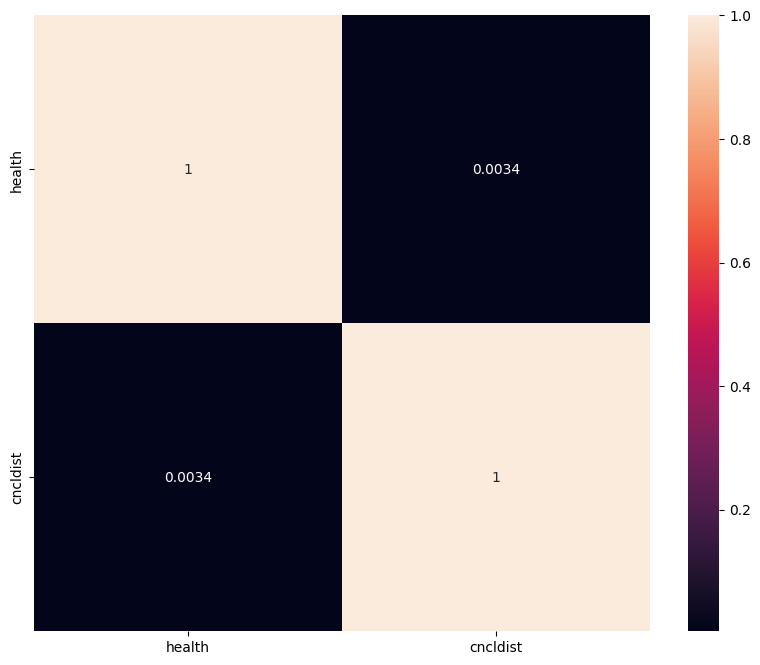

In [14]:
import matplotlib.pyplot as plt

df = train_clean[['health', 'cncldist', ]]

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), square=True, annot=True)
plt.show()


In [43]:
# 一旦lightgbmで学習してみる
# count encodingとラベル削除を行う

# 使わないcolumnを指定
'''
drop_col = [ 'Sneakers', "BranchLights",	"BranchOther",	"MetalGrates",	
            "RootOther",	"Stones",	"Sneakers",	"TrunkLights",	"TrunkOther",
            	"WiresRope","NoProblem"]
'''
drop_col = []
ce_drop_col = ['nta_name', 'boroname', ]
# カテゴリカル変数を指定
ce_columns = ['curb_loc', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'nta',
       'nta_name',  'boro_ct', 'boroname', 
       'spc_genus',  'spc_common', 'cb_num', 'st_senate', 
       'st_assem', 'cncldist', 'borocode', 'zip_city', ]
#  'st_senate', 'st_assem', 'cncldist',
le_columns = []

# カテゴリカルカラムから使わないcolumnを削除
ce_columns = list(set(ce_columns) - set(ce_drop_col))

# 目的変数を指定
y = train_clean['health']

# 使わないcolumnを削除
train_clean_drop = train_clean.drop(['health'], axis=1)
drops = drop_col+ce_drop_col
train_clean_drop = train_clean_drop.drop(drops, axis=1)
test_clean_drop = test_clean.drop(drops,axis=1)


# le
le = LabelEncoder()
for column in le_columns:
    train_clean_drop[column] = le.fit_transform(train_clean_drop[column])
    test_clean_drop[column] = le.transform(test_clean_drop[column])

# カテゴリカル変数を指定
for col in le_columns:
    train_clean_drop[col] = train_clean_drop[col].astype('category')
    test_clean_drop[col] = test_clean_drop[col].astype('category')  

# mergeしてfit, そのあとtransform
all_df = pd.concat([train_clean_drop, test_clean_drop], axis=0)

# count encoding
cencoder = ce.CountEncoder(cols=ce_columns)
cencoder.fit(all_df)

# count encodingを適用
train_clean_drop = cencoder.transform(train_clean_drop)
test_clean_drop = cencoder.transform(test_clean_drop)



In [44]:
train_clean_drop.head()

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,nta,borocode,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist,cos_day,sin_day,year,month,spc_genus
0,14,34828,27383,27573,17291,20910,22673,2405,383,12382,116,383,1551,3529,1061,1583,6.123234e-17,-1.000000,2015,6,7442
1,5,34828,1920,6889,19820,20910,22673,237,52,4131,19,4131,153,521,151,353,-9.961947e-01,-0.087156,2016,9,3343
2,26,34828,27383,27573,19820,20910,1456,2405,579,6834,177,6834,3226,5353,2690,2956,-9.702957e-01,-0.241922,2015,9,7442
4,23,34828,27383,27573,19820,20910,4306,4167,131,4252,37,4204,274,890,391,506,6.975647e-02,-0.997564,2016,6,4167
5,12,34828,27383,27573,17291,20910,22673,20,132,12382,53,1151,1492,3529,486,576,-6.819984e-01,-0.731354,2015,8,20


In [45]:
def f1(y_pred, data):
    y_true = data.get_label()
    score = f1_score(np.argmax(y_pred, axis=1), y_true, average='macro')
    return 'custom', score, True

In [46]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
valid_scores = []
models = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_clean_drop, y)):
    print(f'fold{fold} start')
    X_train, y_train = train_clean_drop.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = train_clean_drop.iloc[valid_idx], y.iloc[valid_idx]

    lgb_train = lgb.Dataset(X_train, y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
    lgb_eval = lgb.Dataset(X_valid, y_valid, weight=np.ones(len(X_valid)).astype('float32'))

    '''
    params = {'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 3,
 'seed': 0,
 'feature_pre_filter': False,
 'lambda_l1': 0.0015923361719036968,
 'lambda_l2': 0.004786876640032096,
 'num_leaves': 252,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.9931160872840541,
 'bagging_freq': 7,
 'min_child_samples': 5,
 'num_iterations': 1000}
 '''
    verbose_eval = -1 # この数字を1にすると学習時のスコア推移がコマンドライン表示される
    params = {'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 3,
 'seed': 0,
 'num_iterations': 1000}
    
    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      num_boost_round=1000,
                       callbacks=[lgb.early_stopping(stopping_rounds=10, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval)], # コマンドライン出力用コールバック関数))
                        # feval=f1,
                        # categorical_feature=le_columns,
                    )

    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)
    score = f1_score(y_valid, y_pred_max, average='macro')
    print(f'fold{fold} f1_score: {score:.4f}')
    valid_scores.append(score)
    models.append(model)
print(f'CV: {np.mean(valid_scores):.4f}')


fold0 start
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1140
[LightGBM] [Info] Number of data points in the train set: 14928, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds


c:\Users\koba_\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[405]	training's multi_logloss: 0.241132	valid_1's multi_logloss: 0.759294
fold0 f1_score: 0.3468
fold1 start
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1143
[LightGBM] [Info] Number of data points in the train set: 14928, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds


c:\Users\koba_\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[400]	training's multi_logloss: 0.247969	valid_1's multi_logloss: 0.769057
fold1 f1_score: 0.3374
fold2 start
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 14928, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds


c:\Users\koba_\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[425]	training's multi_logloss: 0.234289	valid_1's multi_logloss: 0.744301
fold2 f1_score: 0.3537
fold3 start
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 14928, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds


c:\Users\koba_\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[440]	training's multi_logloss: 0.224714	valid_1's multi_logloss: 0.758115
fold3 f1_score: 0.3641
fold4 start
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 14928, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds


c:\Users\koba_\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[428]	training's multi_logloss: 0.22762	valid_1's multi_logloss: 0.754238
fold4 f1_score: 0.3398
CV: 0.3484


In [47]:
y_pred = model.predict(test_clean_drop)
y_pred_max = np.argmax(y_pred, axis=1) # 最尤と判断したクラスの値にする
sample_df[1] = y_pred_max
# sample_df.to_csv('C:/python/signate/data/ceBEST2-dropnta_name, boroname, st_senate, st_assem, borocode.csv', header=None)

ValueError: Length of values (18451) does not match length of index (19702)

In [ ]:
import pandas as pd

importance = model.feature_importance()
feature_names = model.feature_name()

df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
# importtane順に並び替え
df_importance = df_importance.sort_values('Importance', ascending=False)
df_importance


,Feature,Importance
16,cos_day,4823
10,boro_ct,4760
17,sin_day,4456
0,tree_dbh,4315
8,nta,3792
7,spc_common,3492
14,st_assem,2324
6,problems,2301
20,spc_genus,2272
12,cb_num,1999
